# Performing Pseudotime Analysis in R

In this notebook, we will use kallisto tools to perform pseudotime analysis with Slingshot and trajectory-based differential expression. 

#Setup
Using Google colab gives every new notebook a new instance of an Ubuntu machine with R, with some common packages pre-installed. Here, we will install some more packages required for the running of this notebook. This may take some time, as a lot of these packages have other dependencies that also are not pre-installed, as may be the case on your own computer. These dependencies also have C++ code, and compiling the C++ code takes up much of the time in the installation. 

The time it takes to install these first few packages is outputted by the code, as well.


In [1]:
system.time({
install.packages(c("BiocManager", "scales", "viridis", "ggsci"))
BiocManager::install(c("slingshot", "BUSpaRse", "SingleR", 
"DropletUtils", "scater", "scran", "tradeSeq"), Ncpus = 2)
})

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘farver’, ‘gridExtra’


Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'BiocVersion', 'slingshot', 'BUSpaRse', 'SingleR',
  'DropletUtils', 'scater', 'scran', 'tradeSeq'

also installing the dependencies ‘httpuv’, ‘sourcetools’, ‘fastmap’, ‘bit’, ‘formatR’, ‘shiny’, ‘xtable’, ‘bibtex’, ‘iterators’, ‘annotate’, ‘pixmap’, ‘sp’, ‘bit64’, ‘blob’, ‘zlibbioc’, ‘bitops’, ‘Rhtslib’, ‘lambda.r’, ‘futile.options’, ‘interactiveDisplayBase’, ‘pkgmaker’, ‘registry’, ‘rngtools’, ‘gridBase’, ‘foreach’, ‘doParallel’, ‘RcppEigen’, ‘softImpute’, ‘genefilter’, ‘ade4’, ‘rncl’, ‘RNeXML’, ‘Biobase’, ‘IRanges’, ‘RSQLite’, ‘XML’, ‘BiocFileCache’, ‘rappdirs’, ‘XVector’, ‘rtracklayer’, ‘Rsamtools’, ‘ProtGenerics’, ‘RCurl’, ‘GenomeInfoDbData’, ‘GenomicAlignments’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘futile.logger’, ‘snow’, ‘AnnotationHub’, ‘locfit’, ‘R.oo’, ‘R.m

    user   system  elapsed 
4103.819  337.771 2355.417 

In [2]:
devtools::install_github('cole-trapnell-lab/leidenbase')


✔  checking for file ‘/tmp/RtmpTpcowH/remotes7a1547e9f7/cole-trapnell-lab-leidenbase-c22a7d0/DESCRIPTION’
─  preparing ‘leidenbase’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories (584ms)
─  building ‘leidenbase_0.1.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



The ```kb-python``` package lets us call ```kallisto``` and ```bustools``` in one command, instead of having to call both separately.



In [0]:
system("pip3 install kb-python")

In [4]:
library(slingshot)
library(BUSpaRse)
library(DropletUtils)
library(SingleR)
library(tidyverse)
library(Seurat)
library(ggsci)
library(viridis)
library(Matrix)
library(scater)
library(scran)
library(tradeSeq)
library(BiocParallel)
library(clusterExperiment)
theme_set(theme_bw())

Loading required package: princurve

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownam

ERROR: ignored

# Download data

In [0]:
# Download data
if (!dir.exists("./data")) dir.create("./data")
if (!file.exists("./data/neuron_1k_v3_fastqs.tar")) {
  download.file("http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v3/neuron_1k_v3_fastqs.tar", 
      "./data/neuron_1k_v3_fastqs.tar", method = "wget", quiet = TRUE)
}

In [0]:
untar("./data/neuron_1k_v3_fastqs.tar", exdir = "./data")

# Generating the gene count matrix
## Building the ```kallisto``` index with the ```kb``` wrapper

Now, we'll use kallisto to pseudoalign the reads, and create the ```bus``` file that will be converted to a sparse matrix of dimensions genes x cells, representing the number of UMIs per gene per cell.

First, we have to build an index of the  transcriptome and generate the transcriptome transcript-to-gene mapping and FASTA files.

In [0]:
system("kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta",intern=TRUE)

character(0)

Then, we generate the spliced and unspliced matrices. ```kb count``` uses ```kallisto``` to pseudoalign the reads and ```bustools``` to quantify the data.

In [0]:
system("chmod -R 777 data/")

In [0]:
fn <- list.files("data/neuron_1k_v3_fastqs", full.names = TRUE)
fn <- fn[str_detect(fn, "R\\d_")]
fn

[1] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L001_R1_001.fastq.gz"
[2] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L001_R2_001.fastq.gz"
[3] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L002_R1_001.fastq.gz"
[4] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L002_R2_001.fastq.gz"

In [0]:
system(paste("kb count -i reference/mm_tr_index99.idx -g reference/tr2g_mm99.tsv -x 10xv3 -o output",
paste(fn, collapse = " ")), intern = TRUE)

character(0)

# Preprocessing 


In [0]:
res_mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes", tcc = FALSE)

## Removing empty droplets

In [0]:
dim(res_mat)

[1]  36711 399524

There are about ~35k genes and ~400k barcodes. The number of cells seems to be much higher than expected.


In [0]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      1.00      1.00     40.47      5.00 154216.00 

As we can see, most of the cells have very few or no transcripts, indicating empty droplets. To see just how many empty droplets there are, we can look at the inflection point in a ranked UMI knee plot. 

In [0]:
# Compute barcode rank
bc_rank <- barcodeRanks(res_mat, lower = 1000)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(rank, total)) +
    geom_line() +
    geom_hline(aes(yintercept = inflection), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = rank_cutoff), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(x = "Rank", y = "Total UMIs")
  return(p)
}

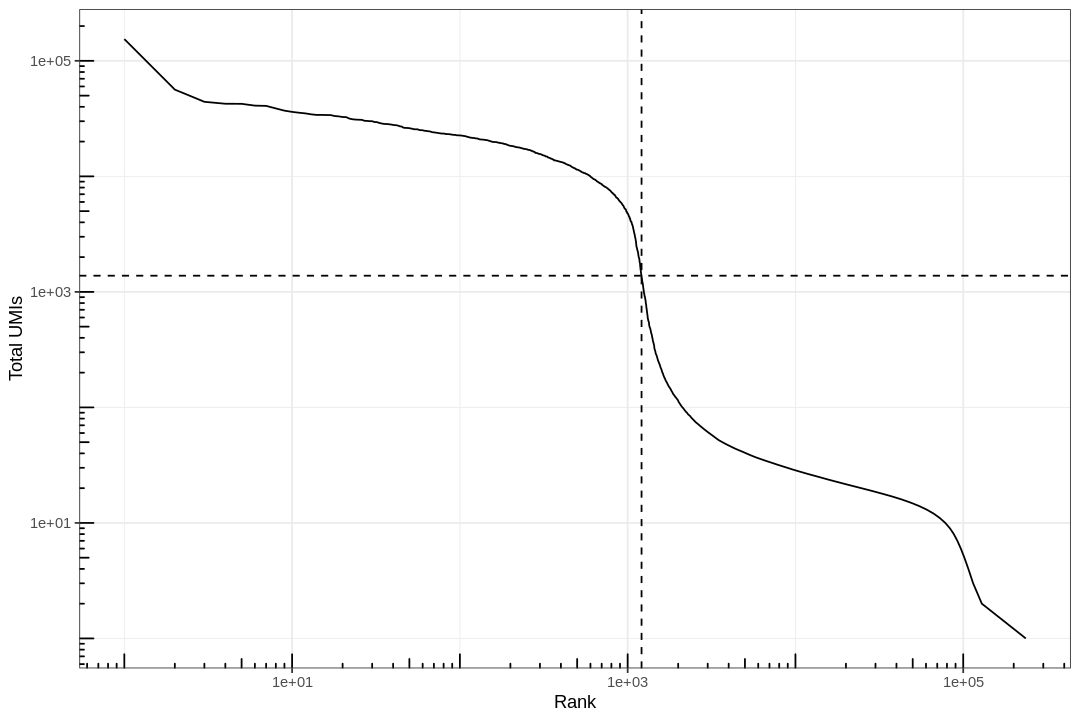

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

Now, we can filter the matrix such that the barcodes to the left of the inflection point (shown on the graph) are left in but those to the right of the inflection point are removed, as they have too few UMIs. 

In [0]:
# Filter the matrix
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 20198  1210

Now, the number of cells (~1k) is closer to what we expect.

In [0]:
rownames(res_mat) <- str_remove(rownames(res_mat), "\\.\\d+")

## Cell type inference
Now, we will infer the cell types, using ```SingleR```, which compares the gene expression of individual cells to the bulk 
RNA-seq data of known cell types, and uses Spearman correlation to assign each cell a label indicating its type. This is important for two reasons: \\
(1) Since pseudotime analyses predict a single trajectory for the data, we must remove all cells that are non-neuronal, as they may be mistaken to be highly differentiated neuronal cells. \\
(2) Cell types are useful in orienting the trajectory (e.g. neuronal progenitor cells must come before neurons). \\

Some of the cell types are in acronym form. Here is what they stand for:
* OPCs: Oligodendrocyte progenitor cells
* NPCs: Neural progenitor cells
* aNSCs: Active neural stem cells
* qNSCs: Quiescent neural stem cells


In [0]:
mouse.rnaseq <- MouseRNAseqData(ensembl = TRUE)
sce <- SingleCellExperiment(assays = list(counts = res_mat))
sce <- logNormCounts(sce)

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

snapshotDate(): 2019-10-22

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

loading from cache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

loading from cache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

snapshotDat

In [0]:
annots <- SingleR(sce, ref = mouse.rnaseq, labels = colData(mouse.rnaseq)$label.fine,
de.method = "wilcox", method = "single", BPPARAM = MulticoreParam(2))

In [0]:
annots

DataFrame with 1210 rows and 5 columns
                                                                        scores
                                                                      <matrix>
AAACGCTGTAATGTGA    0.0601901483760862:0.242986808015721:0.177660752587073:...
AAACGCTGTCCTGGGT      0.11153546550616:0.321858508786419:0.206383027494298:...
AAAGAACCAGGACATG    0.0585569289411892:0.225038532259566:0.177381655702582:...
AAAGGTACACACGGTC       0.137923692580242:0.3506611435018:0.281933499704427:...
AAAGGTATCACCATAG -0.00511350381259525:0.166880227412372:0.0975899954539976:...
...                                                                        ...
TTTGACTTCGTTCAGA     0.100933655338997:0.327948884202836:0.262011719832591:...
TTTGATCTCCATAGGT     0.0656536744266451:0.280702755051776:0.23375860874247:...
TTTGGAGAGGCTAACG    0.0681422805975054:0.234772340818692:0.176292333613646:...
TTTGGTTAGTAATCCC     0.125780004617712:0.315213344287222:0.258722018820061:...
TTTGTTGGTATGG

Then, we filter the data to only include neuronal cells, the cell types of which are indicated below. 

In [0]:
inds <- annots$pruned.labels %in% c("NPCs", "Neurons", "OPCs", "Oligodendrocytes", 
                                    "qNSCs", "aNSCs", "Astrocytes", "Ependymal")
# Only keep these cell types
cells_use <- row.names(annots)[inds]
sce <- sce[, cells_use]
sce$cell_type <- annots$pruned.labels[inds]

# QC

Now, we'll visualize the quality of the data. We compute quality control metrics for each cell and display plots indicating a few features.

In [0]:
df <- perCellQCMetrics(sce)
colData(sce) <- cbind(colData(sce), df)
colData(sce)

DataFrame with 1146 rows and 8 columns
                   cell_type       sum  detected   percent_top_50
                 <character> <numeric> <integer>        <numeric>
AAACGCTGTAATGTGA       aNSCs      7072      3256 19.0328054298643
AAACGCTGTCCTGGGT       aNSCs      9458      4101 12.8991330090928
AAAGAACCAGGACATG       aNSCs      5338      2577 20.7006369426752
AAAGGTACACACGGTC       aNSCs     16892      5111 18.2098034572579
AAAGGTATCACCATAG       aNSCs      1397       882 24.9105225483178
...                      ...       ...       ...              ...
TTTGACTTCGTTCAGA       aNSCs     26203      6091 21.4021295271534
TTTGATCTCCATAGGT       aNSCs      8120      3625 16.7980295566502
TTTGGAGAGGCTAACG     Neurons      5483      2737 21.8675907349991
TTTGGTTAGTAATCCC     Neurons     24381      5927 20.2288667404946
TTTGTTGGTATGGAAT     Neurons      3718      2324 14.6046261430877
                  percent_top_100  percent_top_200  percent_top_500     total
                        <

We first display the sum of counts and nummber of detected features per cell, for each cell type.

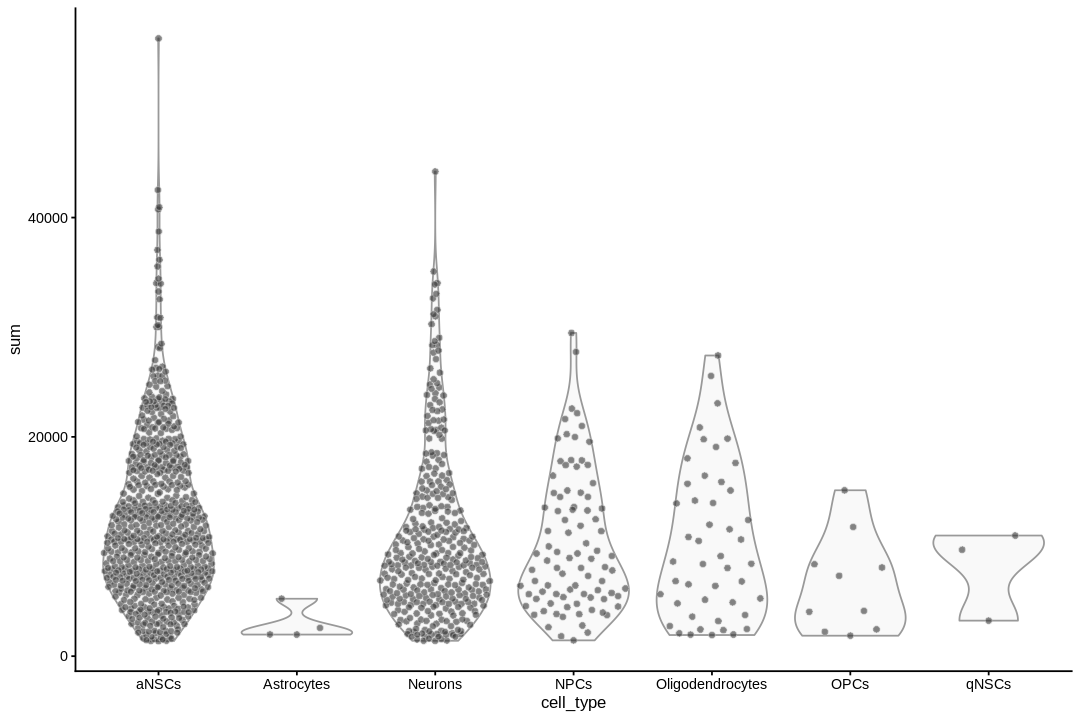

In [0]:
plotColData(sce, x = "cell_type", y = "sum")

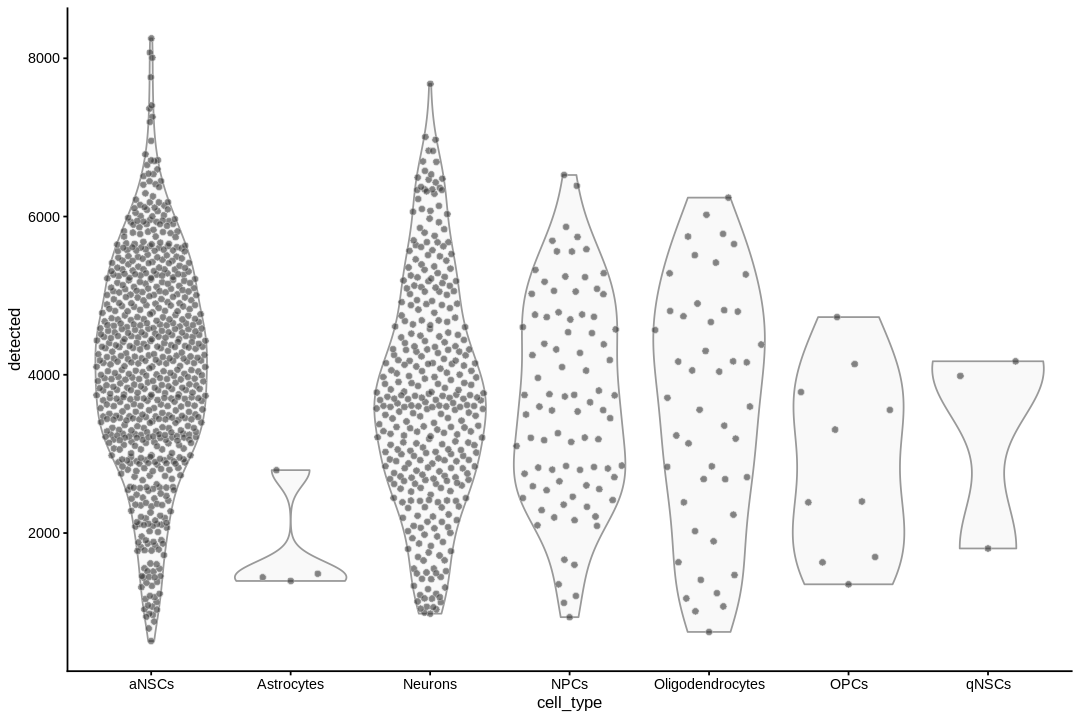

In [0]:
plotColData(sce, x = "cell_type", y = "detected")

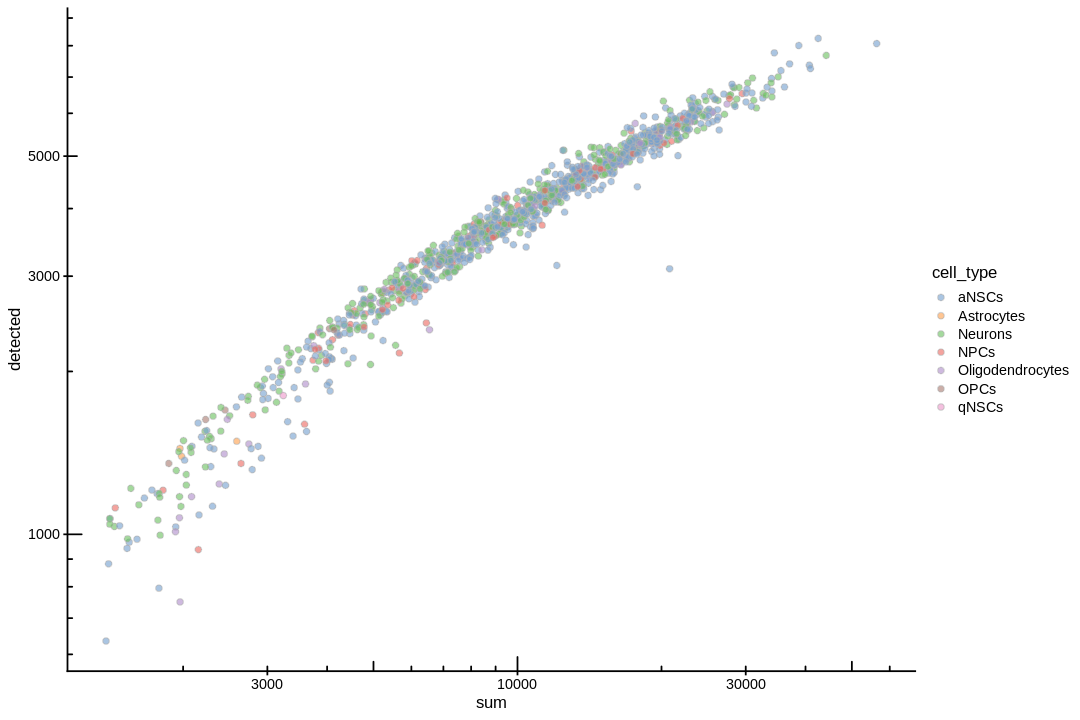

In [0]:
plotColData(sce, x = "sum", y = "detected", colour_by = "cell_type") +
  scale_x_log10() +
  scale_y_log10() +
  annotation_logticks()

Almost all the cell types are generally skewed to having fewer counts, as expected. The distribution of detected features is also approximately normal or uniform for most cell types. 

The relationship between these two factors is similar for all cell types.

## Dimension reduction

We can plot PCA, tSNE and UMAP of the data to visualize the cell populations. First, we'll look at the mean and variance of the variance of each gene.

In [0]:
dec_sce <- modelGeneVar(sce)
fit_pbmc <- metadata(dec_sce)

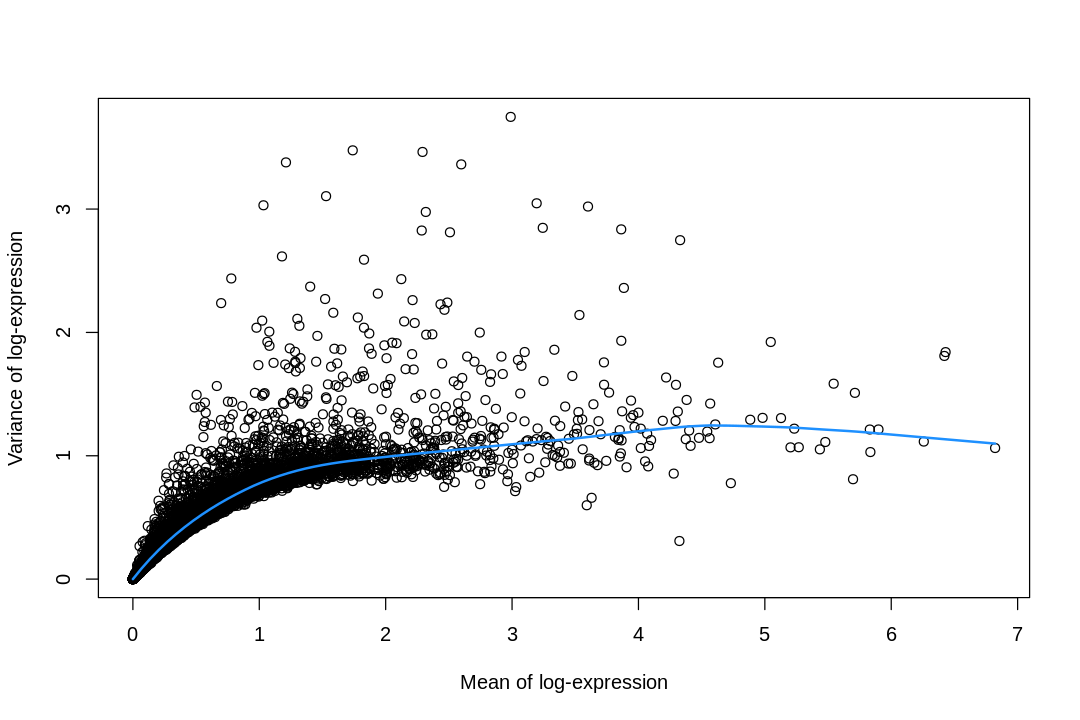

In [0]:
# Adapted from https://osca.bioconductor.org/feature-selection.html#feature-selection
plot(fit_pbmc$mean, fit_pbmc$var, xlab="Mean of log-expression",
    ylab="Variance of log-expression")
curve(fit_pbmc$trend(x), col="dodgerblue", add=TRUE, lwd=2)

Then, to plot PCA, we choose the most variable genes as the principal components. We can see how much variability to the data that each gene contributes.

In [0]:
hvgs <- getTopHVGs(dec_sce, n = 3000)
sce <- runPCA(sce, subset_row = hvgs)

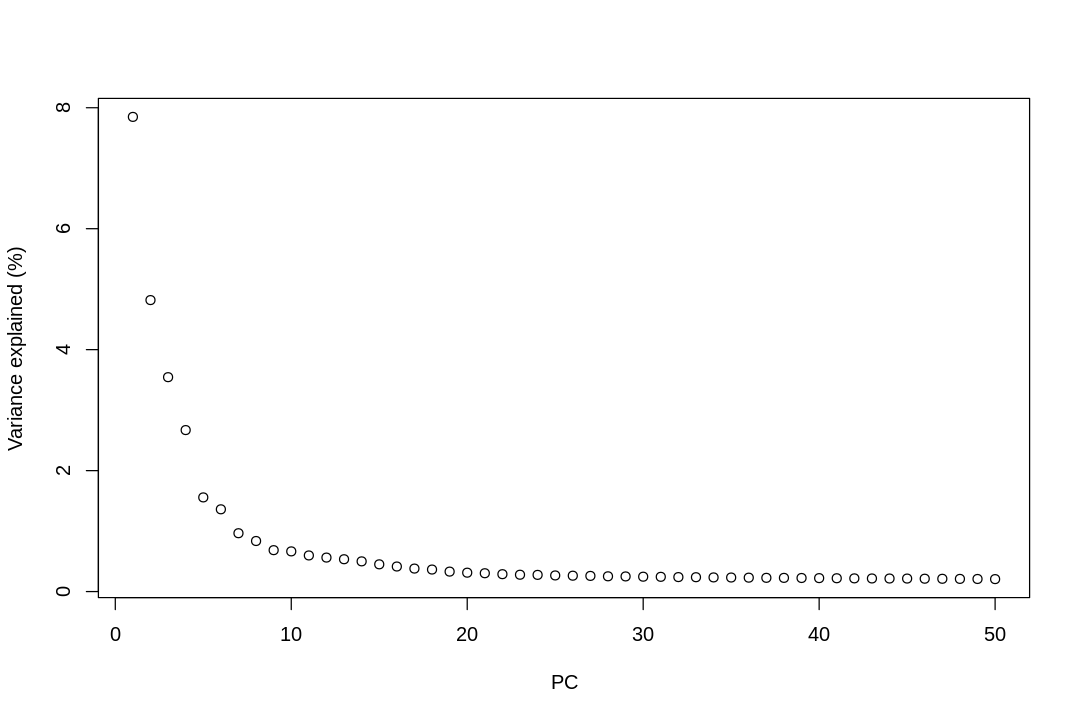

In [0]:
# Percentage of variance explained is tucked away in the attributes.
percent.var <- attr(reducedDim(sce), "percentVar")
plot(percent.var, xlab="PC", ylab="Variance explained (%)")

The y axis is percentage of variance explained by the PC, or the eigenvalues of the covariance matrix.

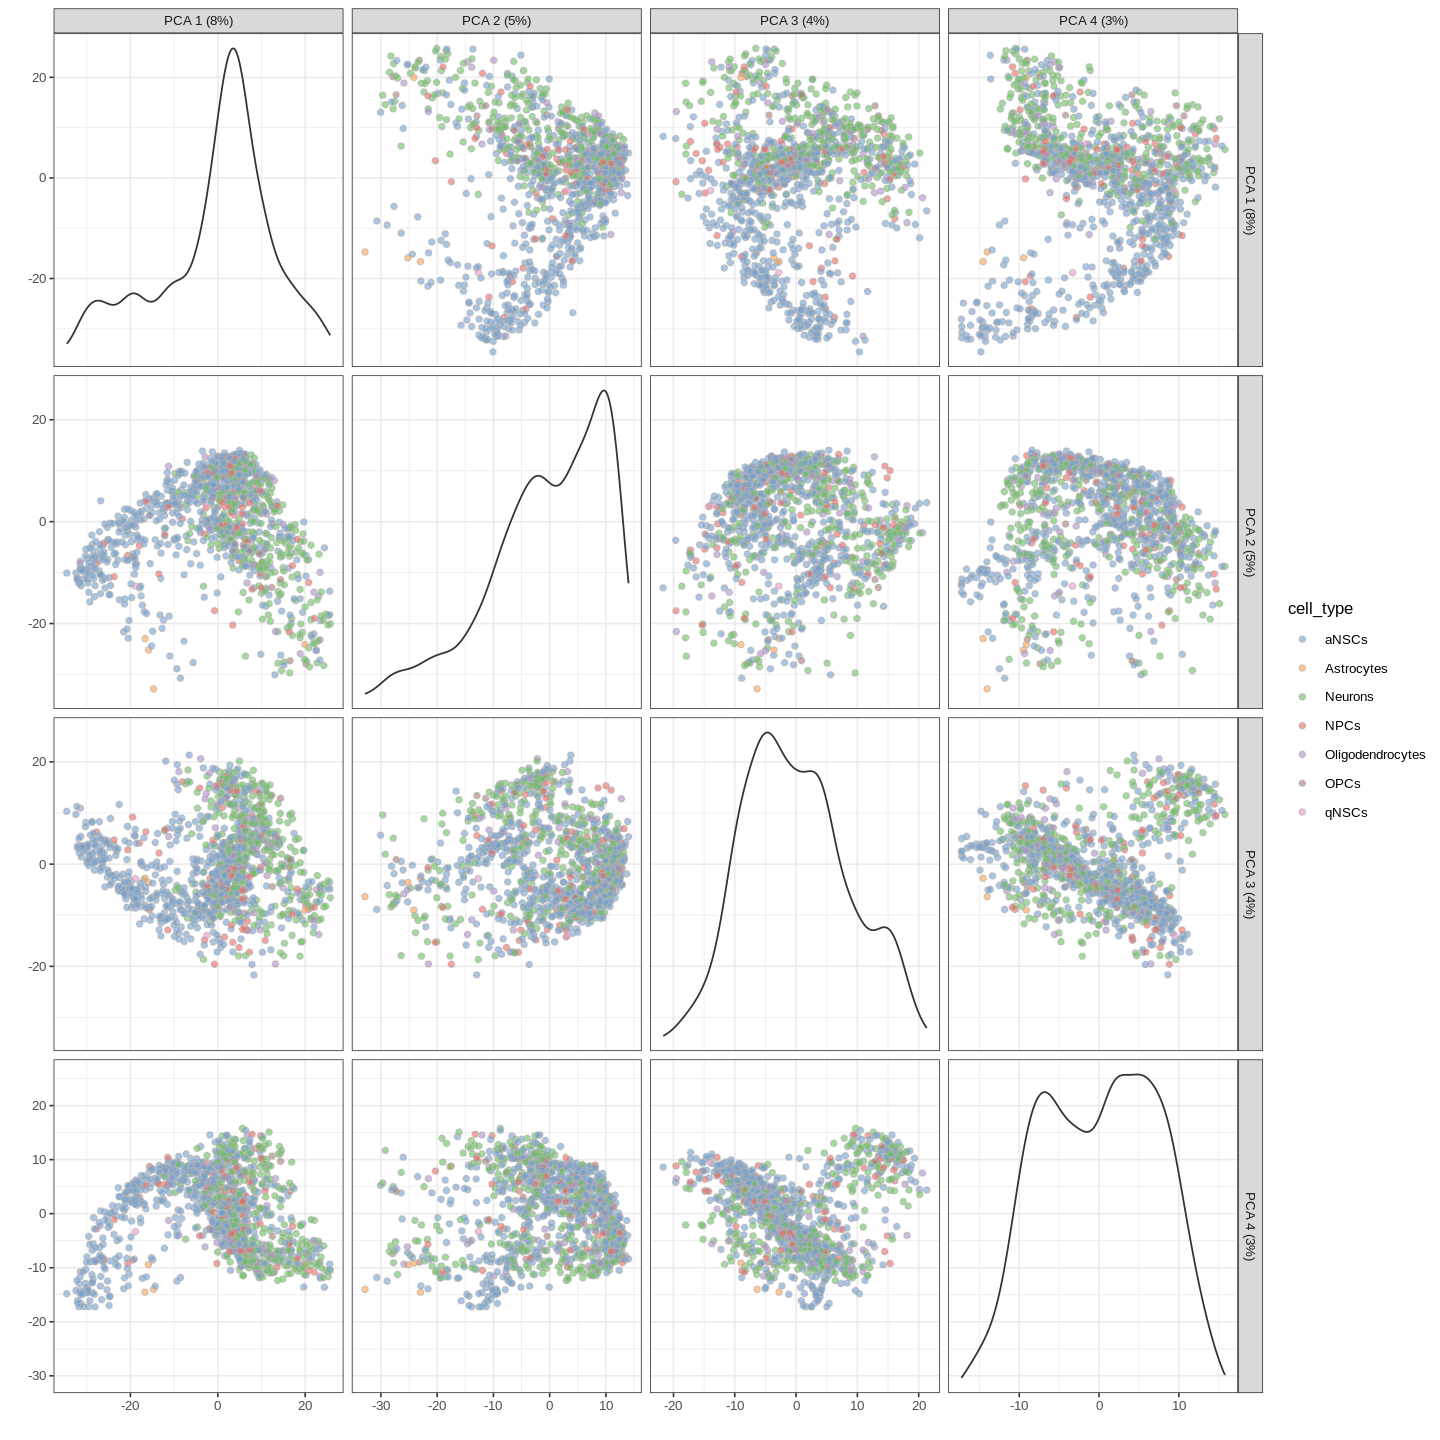

In [0]:
options(repr.plot.width=12, repr.plot.height=12)
plotPCA(sce, colour_by = "cell_type", ncomponents = 4)

Now, we plot tSNE.

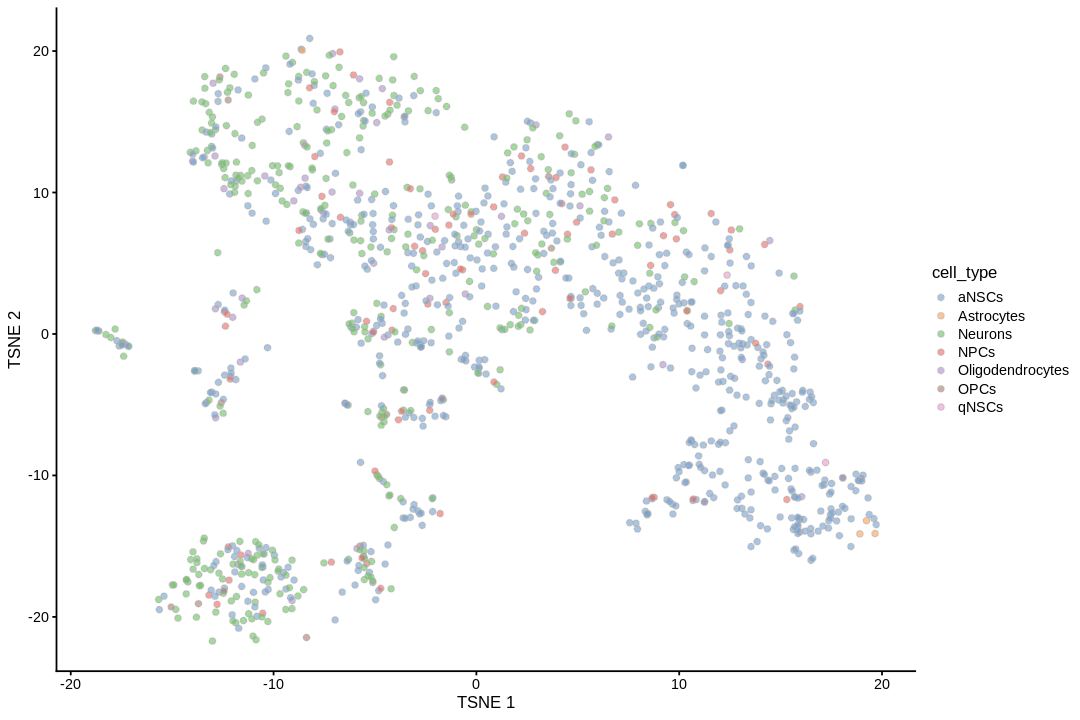

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
sce <- runTSNE(sce, dimred = "PCA")
plotTSNE(sce, colour_by = "cell_type")

Finally, we plot UMAP.

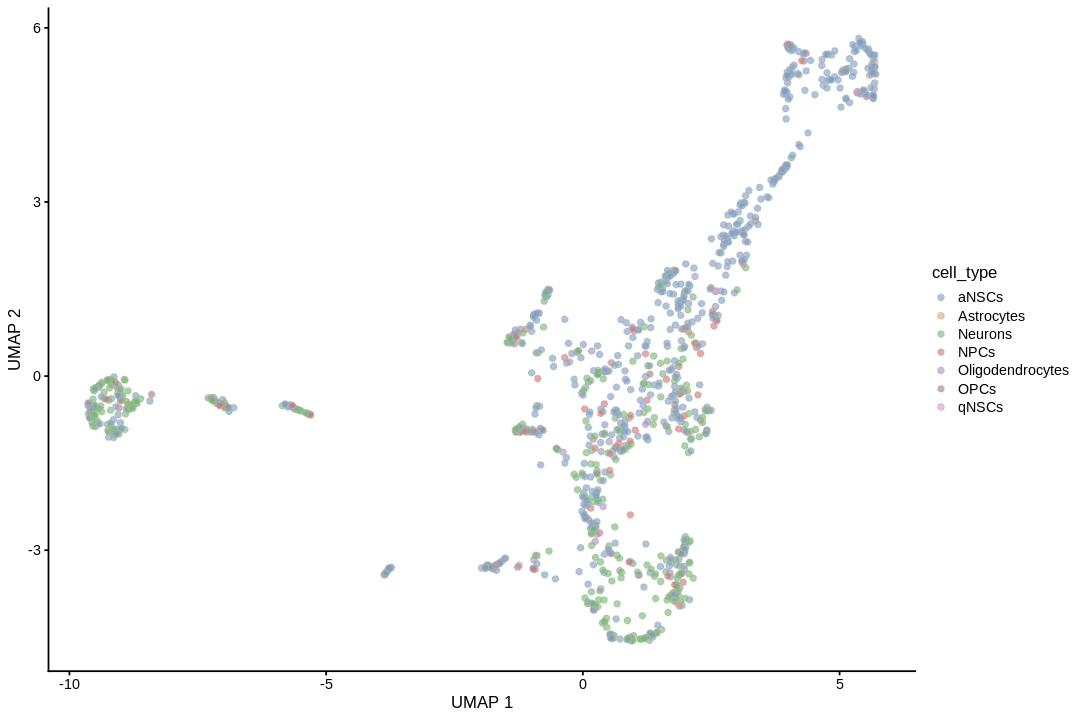

In [0]:
set.seed(1)
sce <- runUMAP(sce, dimred = "PCA", n_neighbors = 30)
plotUMAP(sce, colour_by = "cell_type")

UMAP can better preserve pairwise distance of cells than tSNE and can better separate cell populations than the first 2 PCs of PCA ([Becht et al. 2018](https://doi.org/10.1038/nbt.4314)), so the TI will be visualized on UMAP rather than tSNE or PCA. 

Cell type annotation with `SingleR` requires a reference with bulk RNA seq data for isolated known cell types. The reference used for cell type annotation here does not differentiate between different types of neural progenitor cells; clustering can further partition the neural progenitor cells. Furthermore, `slingshot` is based on cluster-wise minimum spanning tree, so finding a good clustering is important to good trajectory inference with `slingshot`. The clustering algorithm used here is [Leiden](https://www.nature.com/articles/s41598-019-41695-z), which is an improvement over the commonly used Louvain; Leiden communities are guaranteed to be well-connected, while Louvain can lead to poorly connected communities.

In [0]:
g <- buildSNNGraph(sce, k = 15, use.dimred = "PCA")

In [0]:
sce$cluster <- leidenbase::leiden_find_partition(g, resolution_parameter = 1.2, 
  partition_type = "RBConfigurationVertexPartition",
  num_iter = 10, seed = 1)$membership %>% factor()

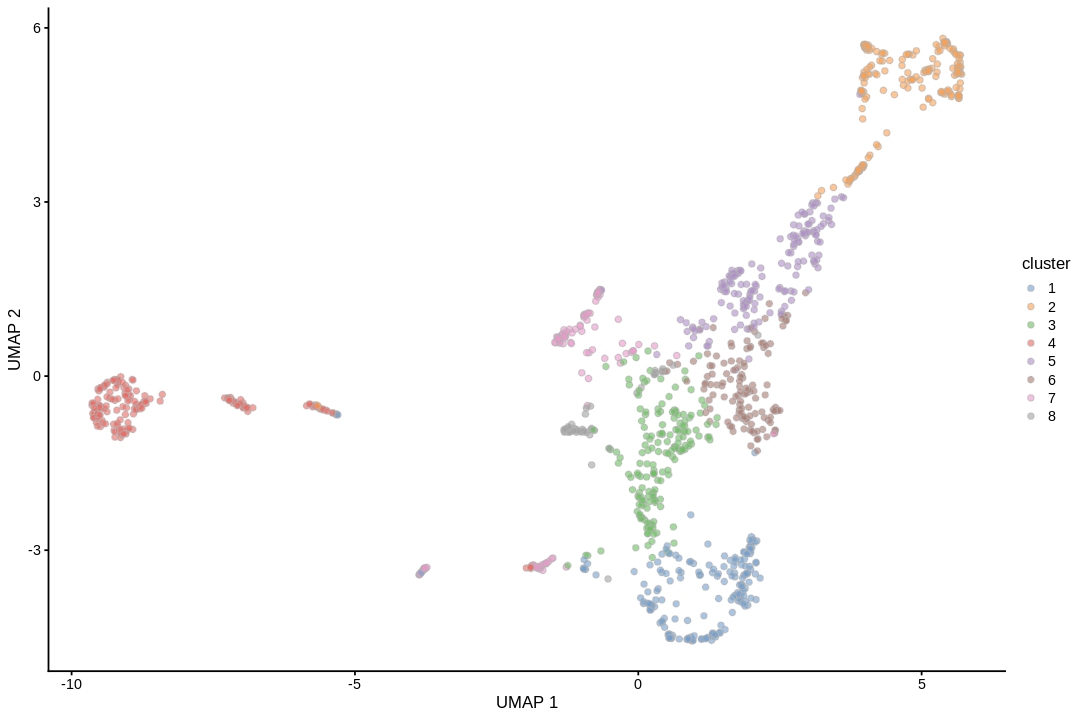

In [0]:
plotUMAP(sce, colour_by = "cluster")

# Slingshot
## Trajectory inference
While the `slingshot` vignette uses `SingleCellExperiment`, `slingshot` can also take a matrix of cell embeddings in reduced dimension as input. We can optionally specify the cluster to start or end the trajectory based on biological knowledge. Here, since quiescent neural stem cells are in cluster 4, the starting cluster would be 4 near the top left of the previous plot.

**I no longer consider doing trajectory inference on UMAP a good idea**, due to distortions introduced by UMAP. See [this paper](https://www.biorxiv.org/content/10.1101/689851v3) for the extent non-linear dimension reduction methods distort the data. The latent dimension of the data is most likely far more than 2 or 3 dimensions, so forcing it down to 2 or 3 dimensions are bound to introduce distortions, just like how projecting the spherical surface of the Earth to 2 dimensions in maps introduces distortions. Furthermore, after the projection, some trajectories are no longer topologically feasible. For instance, imagine a stream coming out of the hole of a doughnut in 3D. This is not possible in 2D, so when that structure is projected to 2D, part of the stream may become buried in the middle of the doughnut, or the doughnut may be broken to allow the stream through, or part of the steam will be intermixed with part of the doughnut though they shouldn't. I recommend using a larger number of principal components instead, but in that case, the lineages and principal curves can't be visualized (we can plot the curves within a 2 dimensional subspace, such as the first 2 PCs, but that usually looks like abstract art and isn't informative about the lineages).

In [0]:
sds <- slingshot(reducedDim(sce, "PCA")[,1:20], clusterLabels = sce$cluster, 
                 start.clus = 2, stretch = 0)

Using full covariance matrix



Unfortunately, `slingshot` does not natively support `ggplot2`. So this is a function that assigns colors to each cell in base R graphics.

In [0]:
#' Assign a color to each cell based on some value
#' 
#' @param cell_vars Vector indicating the value of a variable associated with cells.
#' @param pal_fun Palette function that returns a vector of hex colors, whose
#' argument is the length of such a vector.
#' @param ... Extra arguments for pal_fun.
#' @return A vector of hex colors with one entry for each cell.
cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

We need color palettes for both cell types and Leiden clusters. These would be the same colors seen in the Seurat plots.

In [0]:
cell_colors <- cell_pal(sce$cell_type, pal_d3(alpha = 0.5))
cell_colors_clust <- cell_pal(sce$cluster, pal_d3(alpha = 0.5))

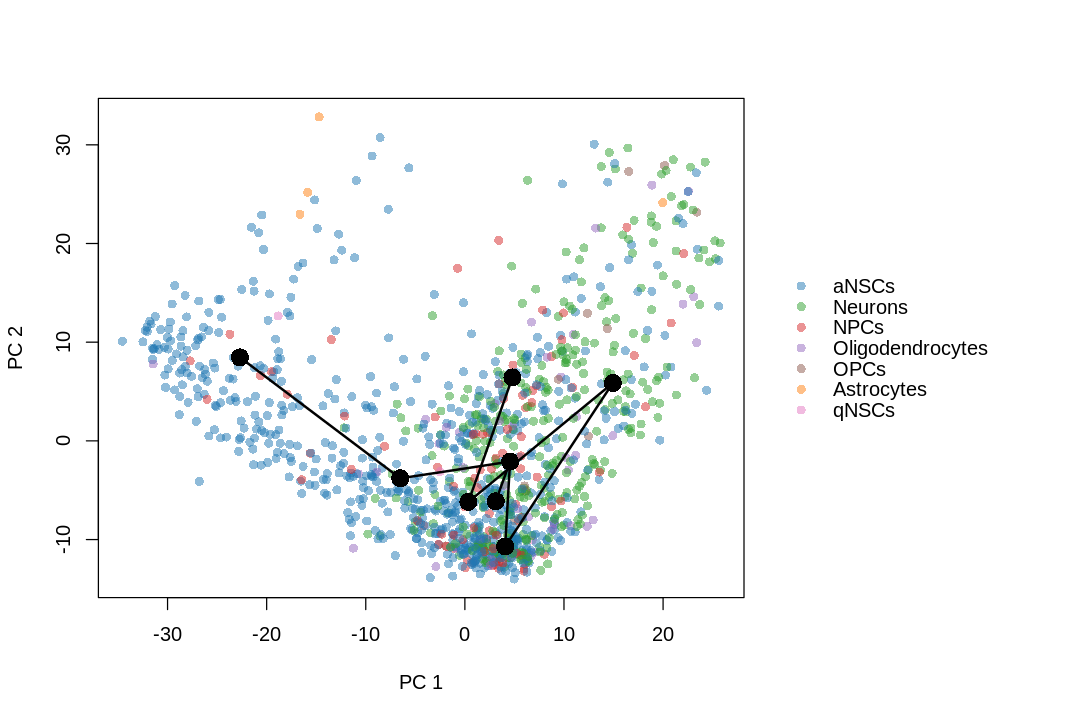

In [0]:
par(mar=c(5.1, 4.1, 4.1, 14), xpd=TRUE)
plot(reducedDim(sds, "PCA")[,1:2], col = cell_colors, pch = 16, cex = 1, xlab = "PC 1", ylab = "PC 2")
lines(sds, lwd = 2, type = 'lineages', col = 'black')
legend("right", inset = c(-0.6, 0), legend = unique(sce$cell_type), 
       col = unique(cell_colors), pch = 16, box.lwd = 0)

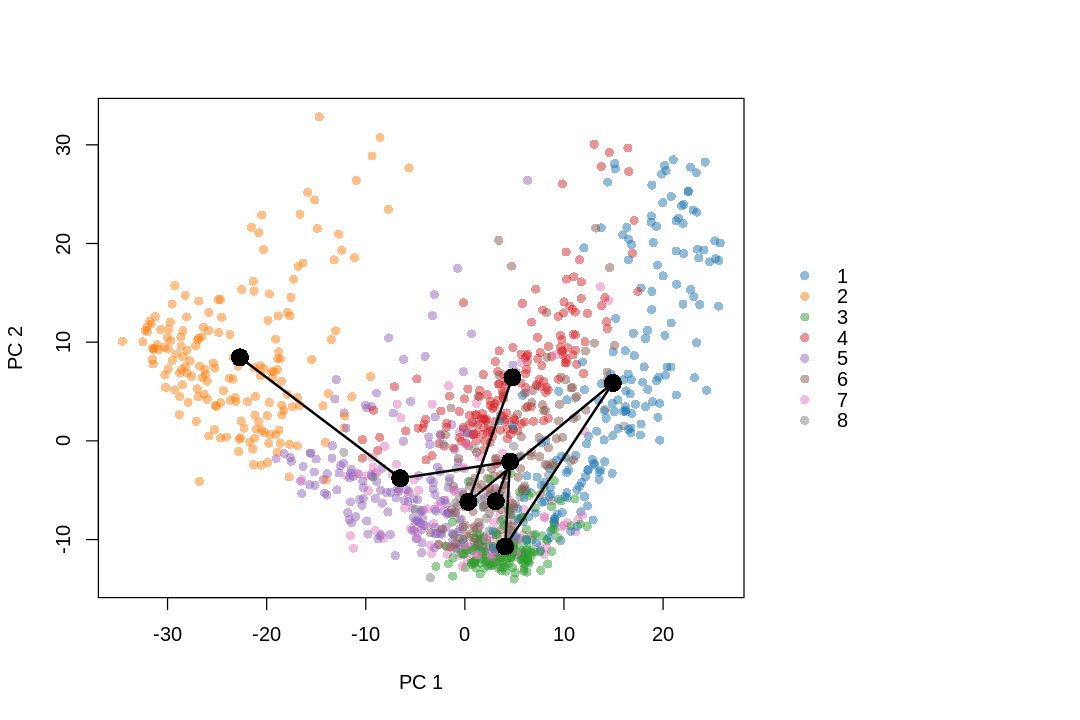

In [0]:
ord <- order(unique(sce$cluster))
par(mar=c(5.1, 4.1, 4.1, 14), xpd=TRUE)
plot(reducedDim(sds, "PCA")[,1:2], col = cell_colors_clust, pch = 16, cex = 1, xlab = "PC 1", ylab = "PC 2")
lines(sds, lwd = 2, type = 'lineages', col = 'black')
legend("right", inset = c(-0.2, 0), legend = unique(sce$cluster)[ord], 
       col = unique(cell_colors_clust)[ord], pch = 16, box.lwd = 0)

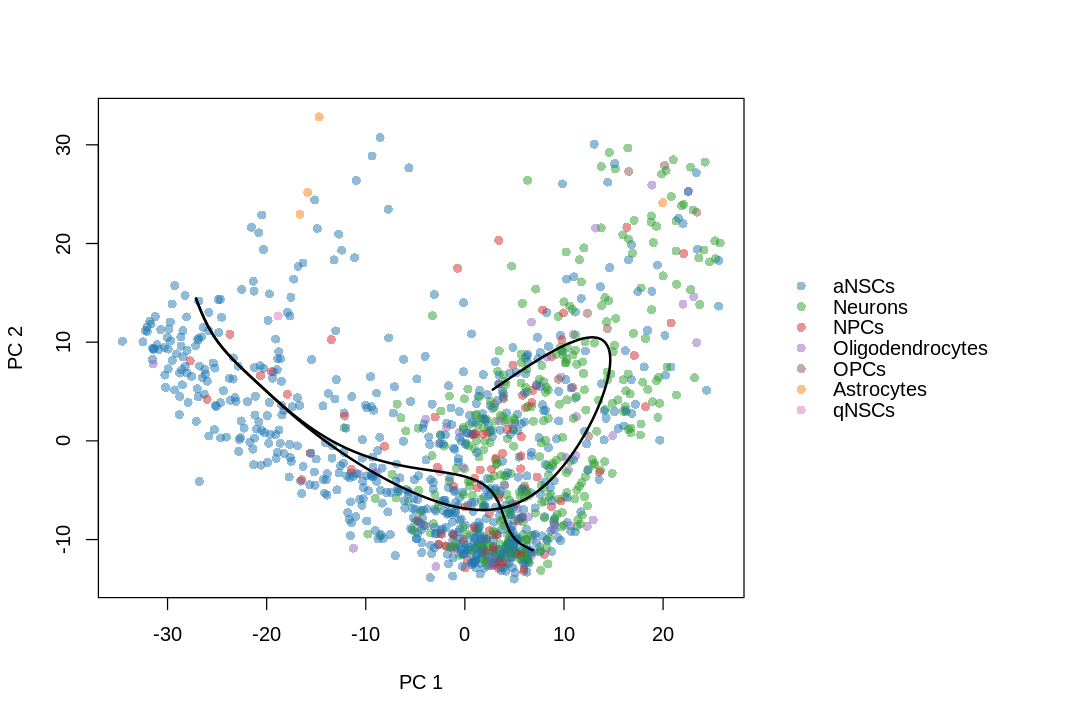

In [0]:
par(mar=c(5.1, 4.1, 4.1, 14), xpd=TRUE)
plot(reducedDim(sds, "PCA")[,1:2], col = cell_colors, pch = 16, cex = 1, xlab = "PC 1", ylab = "PC 2")
lines(sds, lwd = 2, col = 'black')
legend("right", inset = c(-0.6, 0), legend = unique(sce$cell_type), 
       col = unique(cell_colors), pch = 16, box.lwd = 0)

Which cells are in which lineage? Here we plot the pseudotime values for each lineage.

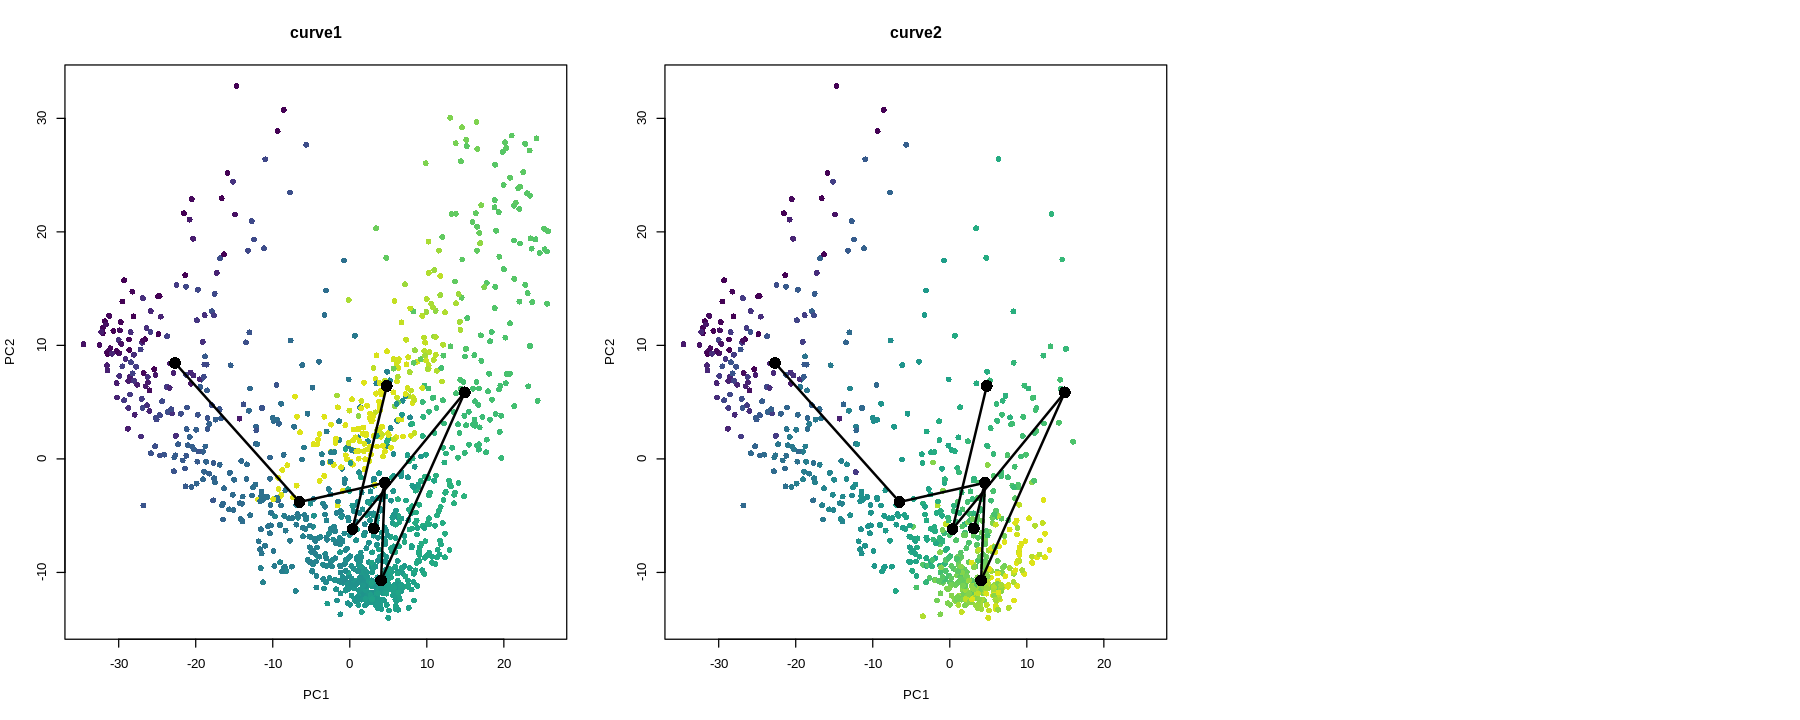

In [0]:
options(repr.plot.width=15, repr.plot.height=6)
nc <- 3
pt <- slingPseudotime(sds)
nms <- colnames(pt)
nr <- ceiling(length(nms)/nc)
pal <- viridis(100, end = 0.95)
par(mfrow = c(nr, nc))
for (i in nms) {
  colors <- pal[cut(pt[,i], breaks = 100)]
  plot(reducedDim(sds), col = colors, pch = 16, main = i)
  lines(sds, lwd = 2, col = 'black', type = 'lineages')
}

Or on UMAP, though can't plot the lineages here.

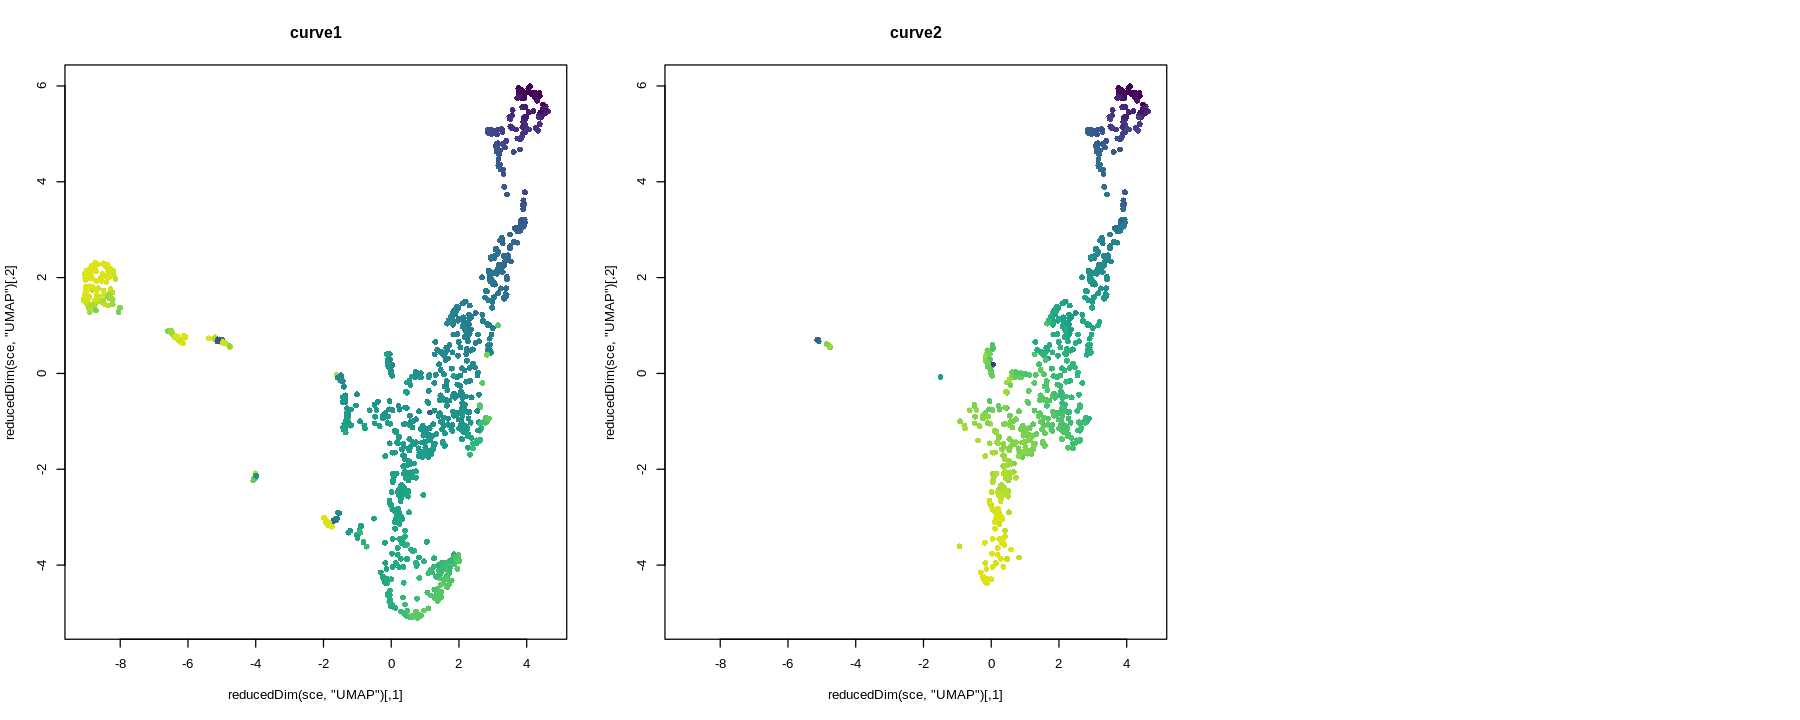

In [0]:
par(mfrow = c(nr, nc))
options(repr.plot.width=15, repr.plot.height=6)
for (i in nms) {
  colors <- pal[cut(pt[,i], breaks = 100)]
  plot(reducedDim(sce, "UMAP"), col = colors, pch = 16, main = i)
}

# Differential expression
## Fitting the NB-GAM 

Now, here we use the package `tradeSeq`, presented in [this paper](https://www.biorxiv.org/content/10.1101/623397v1), for modelling gene expression as a function of pseudotime. This section was adapted from the vignette of `tradeSeq`. 

We will first determine the optimal number of knots to select in order for the NB-GAM model to best fit the data. Typically, the interesting range of number of knots is from 3 to 10, so we'll look at how the Akaike information criterion (AIC) (an estimator for out-of-sample error) changes relative to these values.

Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Fitting terminated with step failure - check results carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Iteration limit reached without full convergence - check carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Fitting terminated with step failure - check results carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Fitting terminated with step failure - check results carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Iteration limit reached without full convergence - check carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Fitting terminated with step failure - check results carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$

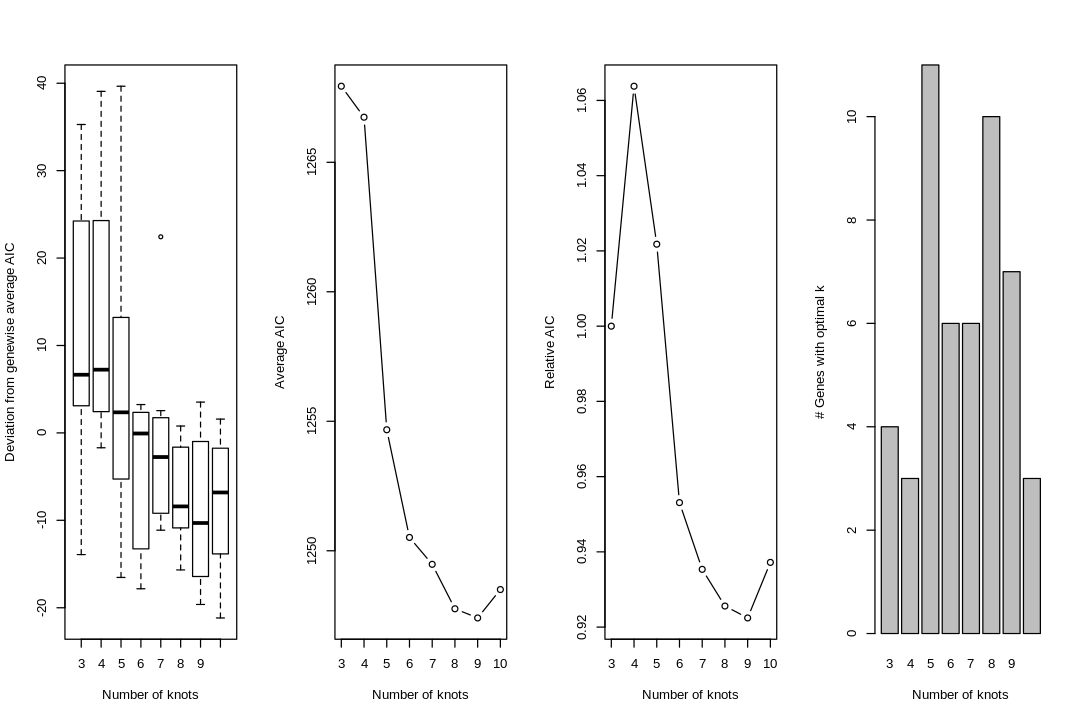

In [0]:
control <- mgcv::gam.control()
control$maxit <- 1000
cts <- as.matrix(counts(sce))
icMat <- evaluateK(counts = cts, k=3:10, nGenes = 50,
                   pseudotime = slingPseudotime(sds, na = FALSE),
                   cellWeights = slingCurveWeights(sds), control = control)

As we can see from the middle two graphs, the AIC tends doesn't decrease too much  after about 5 knots, and a value of 5 results in the largest number of genes with optimal K. So, we select ```nknots = 5```. 

In [0]:
register(MulticoreParam(2))
sce2 <- fitGAM(counts = cts[hvgs[1:50],], sds = sds, nknots = 5, control = control)

Let's see where the knots are.

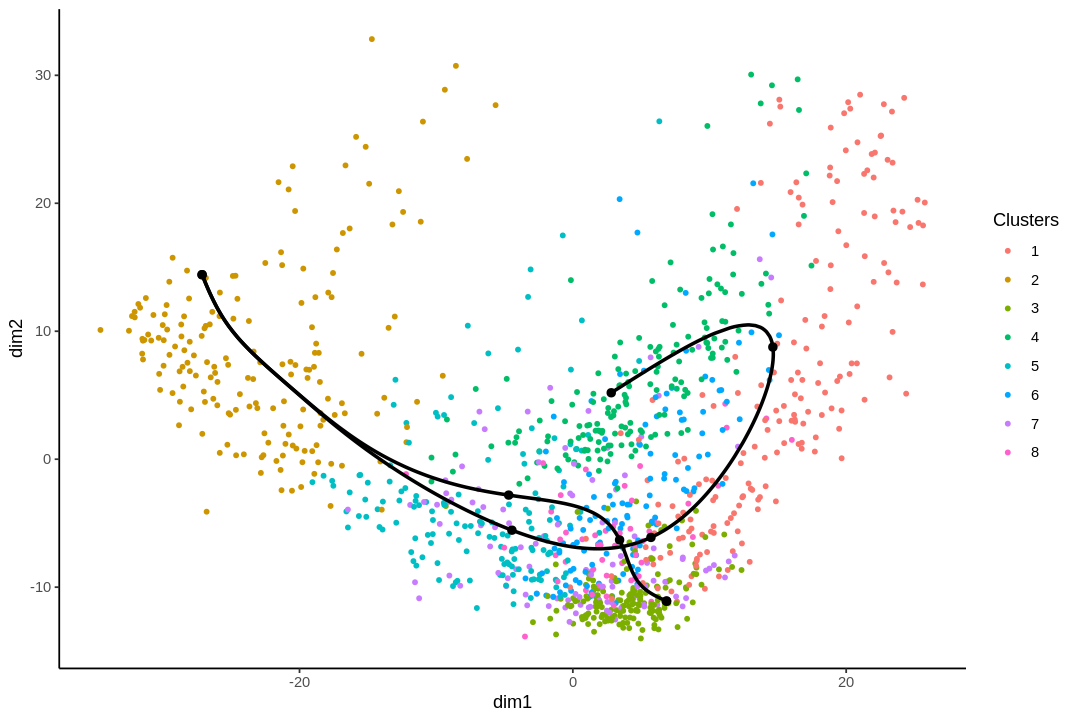

In [0]:
plotGeneCount(curve = sds, clusters = sce$cluster,
              models = sce2)

## Within lineage comparisons
Now we can do some exploratory data analysis. First, let's check if gene expression is associated with a specific lineage. ```associationTest``` will run a chi-square test, to see if the average gene expression significantly changes across pseudotime.

In [0]:
assoRes <- associationTest(sce2)
head(assoRes)

waldStat  df pvalue
ENSMUSG00000027500  749.6209 7  0     
ENSMUSG00000019874 1765.8955 7  0     
ENSMUSG00000005583  579.4966 7  0     
ENSMUSG00000029838  504.3415 7  0     
ENSMUSG00000027210  492.3774 7  0     
ENSMUSG00000026728 1072.9275 7  0

It appears as if gene expression is indeed correlated with pseudotime along a particular lineage.

Now we can check for differential expression between the start and end points of the smoothers across all lineages, to see the most significant genes that are markers of the differentiation. 

In [0]:
startRes <- startVsEndTest(sce2)

We can plot the smoothers of the most significant gene.

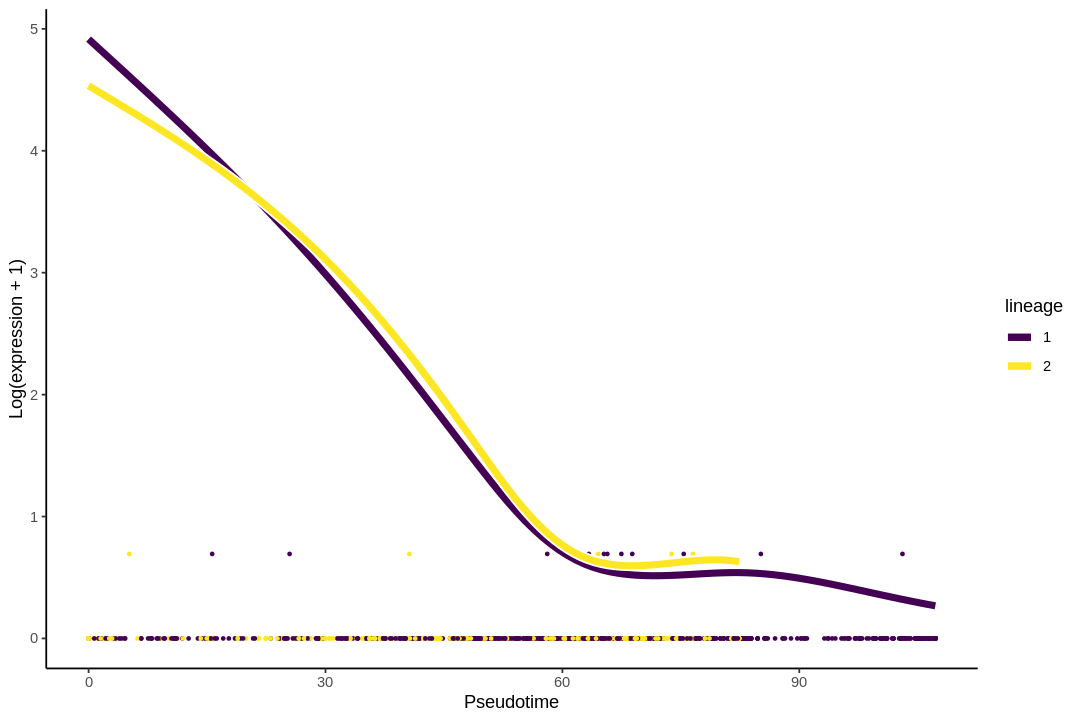

In [0]:
oStart <- order(startRes$waldStat, decreasing = TRUE)
sigGeneStart <- names(sce2)[oStart[1]]
plotSmoothers(sce2, cts, gene = sigGeneStart)

We can also see the expression of this gene over the cells on a UMAP. 

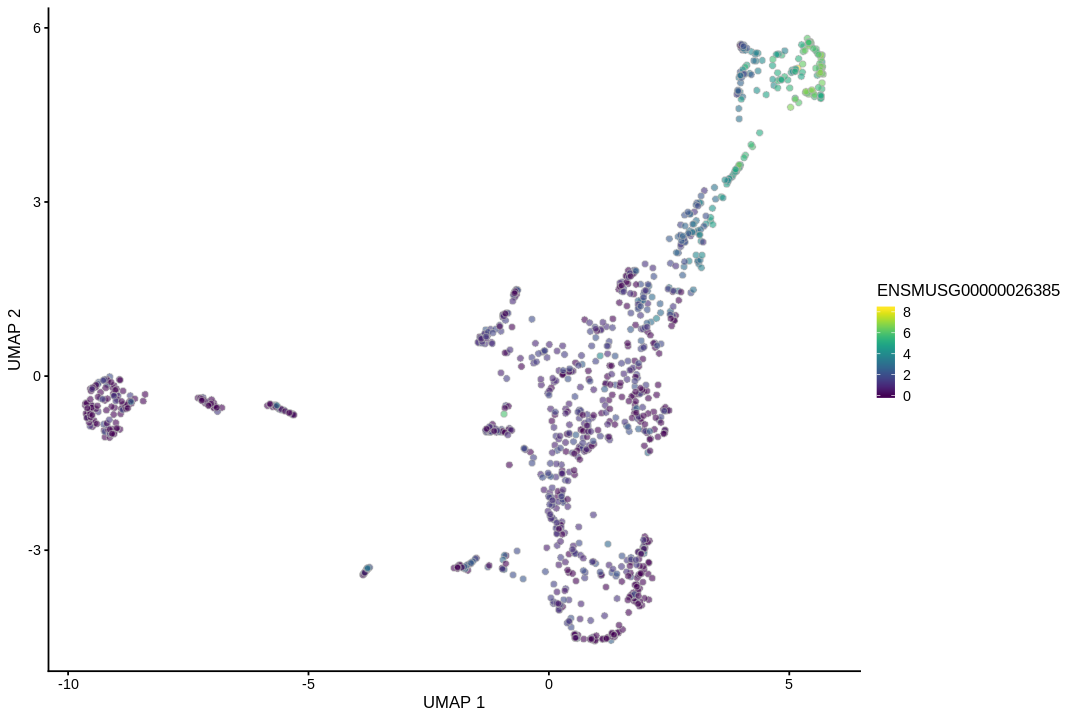

In [0]:
plotUMAP(sce, colour_by = sigGeneStart)

## Between lineage comparisons

We can also see significant genes by comparing expression between lineages. ```diffEndTest``` will test to see if there are differences in expression between the endpoints of the smoothers between all lineages. 

In [0]:
endRes <- diffEndTest(sce2)

We can plot the smoothers of the most significant gene.

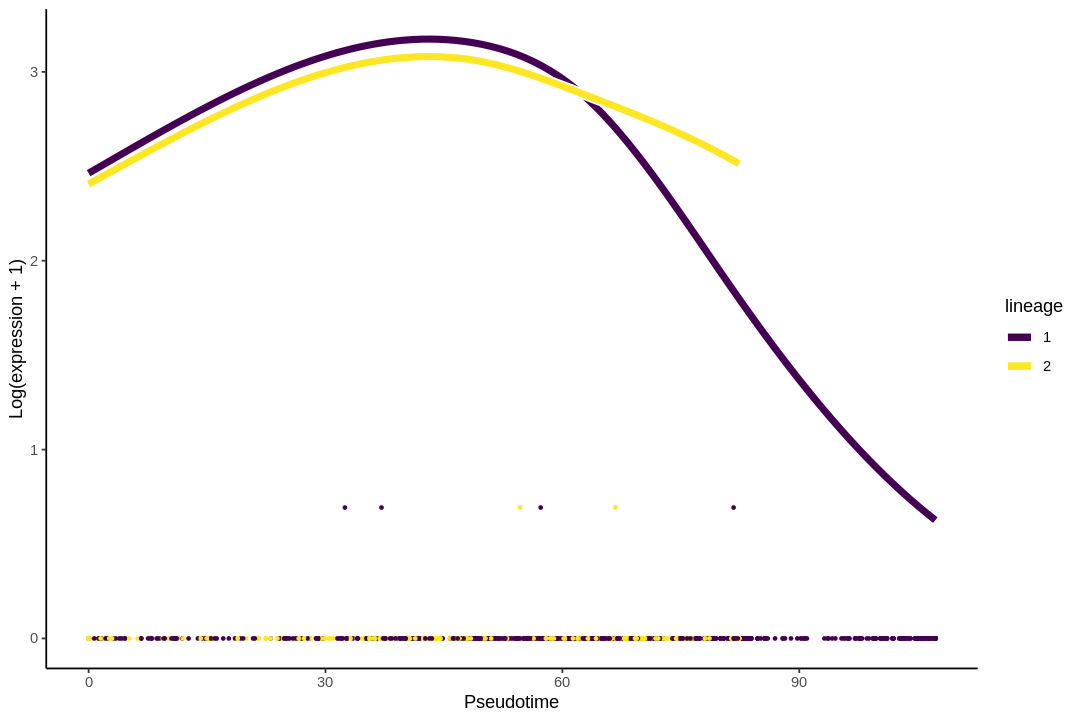

In [0]:
o <- order(endRes$waldStat, decreasing = TRUE)
sigGene <- names(sce2)[o[1]]
plotSmoothers(sce2, cts, sigGene)

We can also see the expression of this gene over the cells on a UMAP.

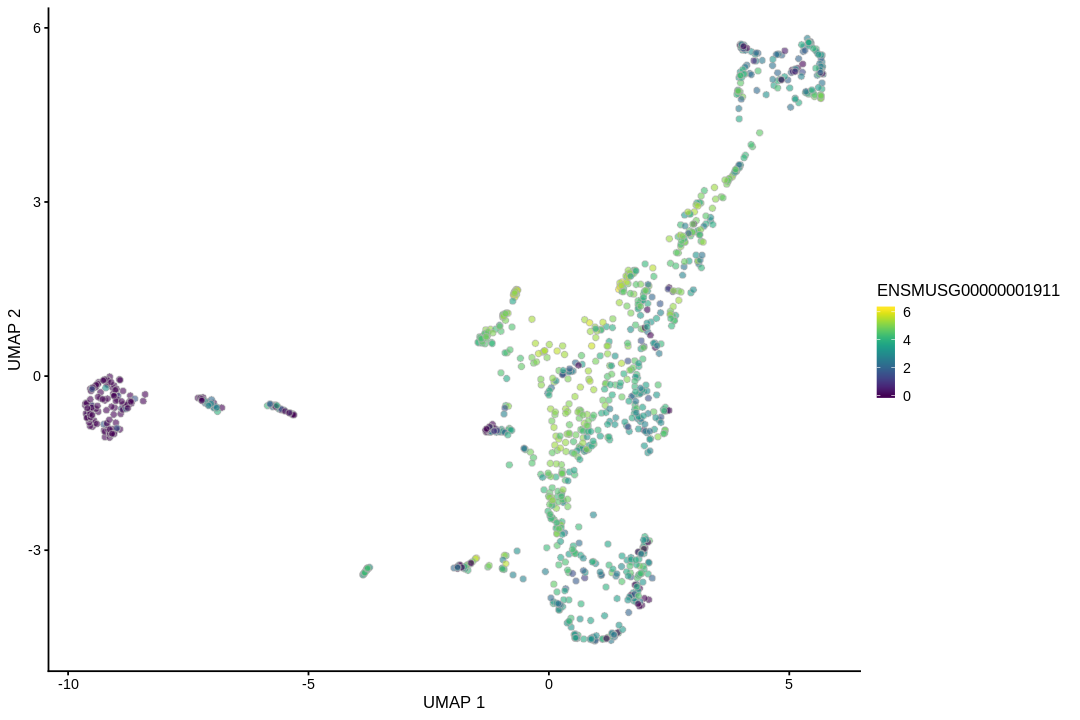

In [0]:
plotUMAP(sce, colour_by = sigGene)

## Different patterns

We can also look at how the expression patterns of genes varies across pseudotime. ```patternTest``` tests to see if smoothed gene expression differs along pseudotime between lineages. 

In [0]:
patternRes <- patternTest(sce2)
oPat <- order(patternRes$waldStat, decreasing = TRUE)
head(rownames(patternRes)[oPat])

[1] "ENSMUSG00000035551" "ENSMUSG00000027239" "ENSMUSG00000018411"
[4] "ENSMUSG00000067786" "ENSMUSG00000052727" "ENSMUSG00000058672"

We can plot the smoothers of the most significant gene.

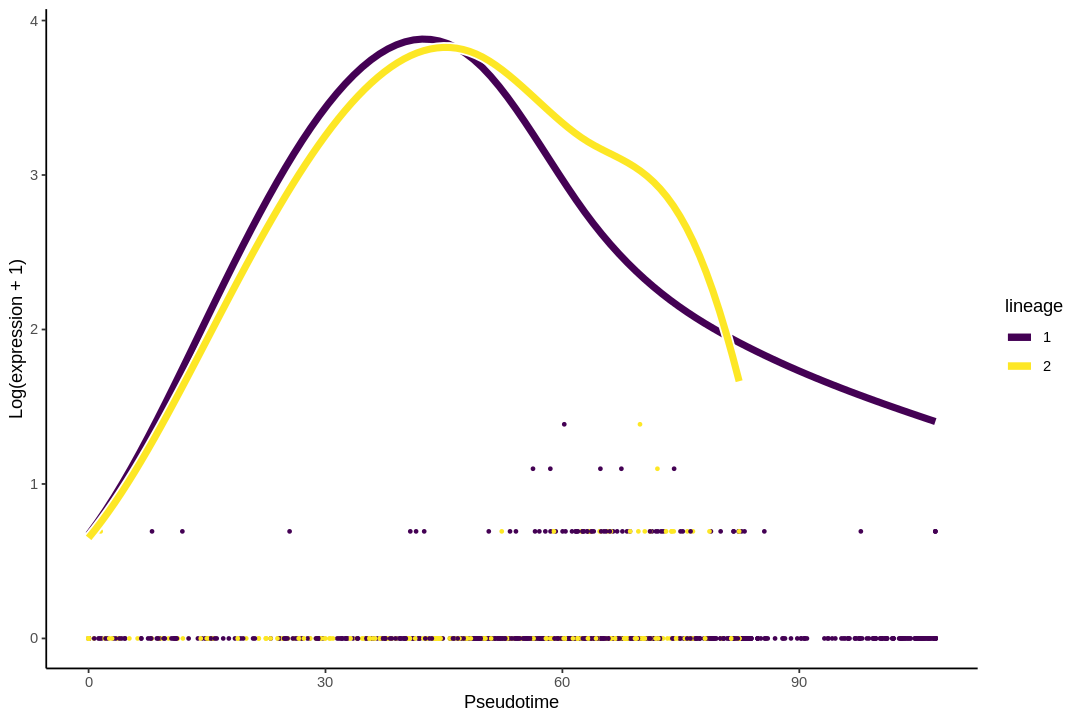

In [0]:
plotSmoothers(sce2, cts, gene = rownames(patternRes)[oPat][1])

We can also see the expression of this gene over the cells on a UMAP.

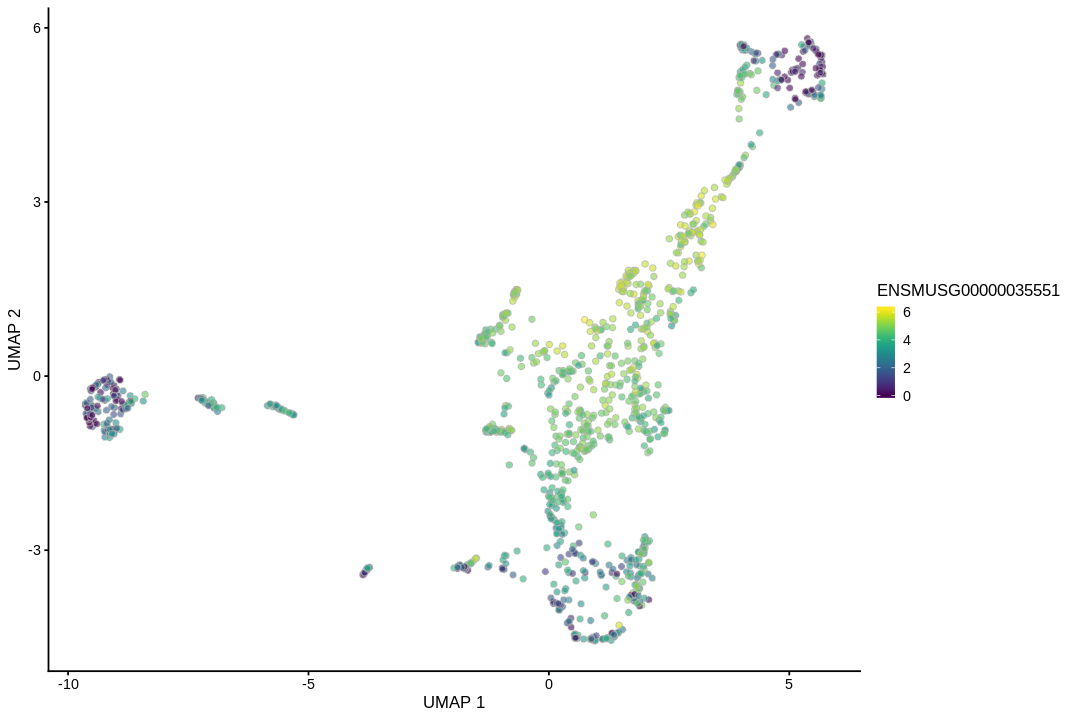

In [0]:
plotUMAP(sce, colour_by = rownames(patternRes)[oPat][1])

## Clustering patterns
We can also cluster genes according to similar expression patters across all lineages, using ```clusterExpressionPatterns```. We'll use 10 points along each lineage to perform the clustering.


In [0]:
nPointsClus <- 10
clusPat <- clusterExpressionPatterns(sce2, nPoints = nPointsClus,
                                     genes = rownames(sce2))

In [0]:
clusterLabels <- primaryCluster(clusPat$rsec)

We can plot the normalized expression vs pseudotime for the first 4 clusters, for both lineages. 

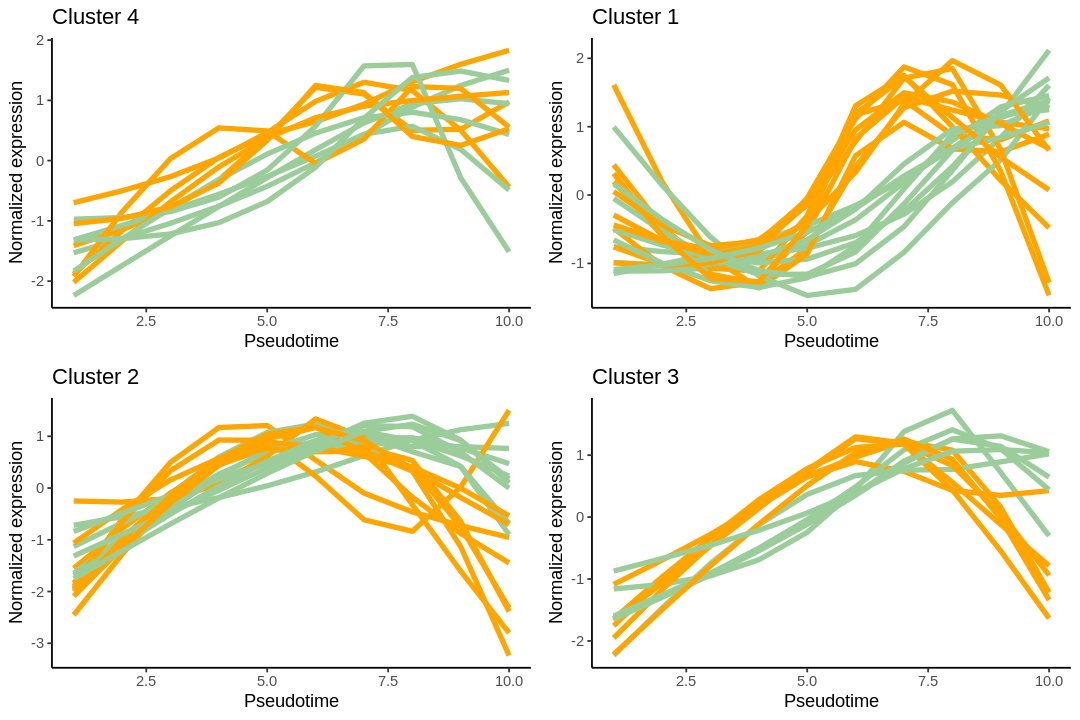

In [0]:
cUniq <- unique(clusterLabels)
cUniq <- cUniq[!cUniq == -1] # remove unclustered genes

plots <- list()
for (xx in cUniq[1:4]) {
  cId <- which(clusterLabels == xx)
  p <- ggplot(data = data.frame(x = 1:nPointsClus,
                                y = rep(range(clusPat$yhatScaled[cId, ]),
                                        nPointsClus / 2)),
              aes(x = x, y = y)) +
    geom_point(alpha = 0) +
    labs(title = paste0("Cluster ", xx),  x = "Pseudotime", y = "Normalized expression") +
    theme_classic()
  for (ii in 1:length(cId)) {
    geneId <- rownames(clusPat$yhatScaled)[cId[ii]]
    p <- p +
      geom_line(data = data.frame(x = rep(1:nPointsClus, 2),
                                  y = clusPat$yhatScaled[geneId, ],
                                  lineage = rep(0:1, each = nPointsClus)),
                aes(col = as.character(lineage), group = lineage), lwd = 1.5)
  }
  p <- p + guides(color = FALSE) +
    scale_color_manual(values = c("orange", "darkseagreen3"),
                       breaks = c("0", "1"))  
  plots[[as.character(xx)]] <- p
}
plots$ncol <- 2
do.call(cowplot::plot_grid, plots)
